# [lightGBN benchmark](https://www.kaggle.com/waxbabi/light-gbm-benchmark-0-3692) 그대로 구현해서 임시로 만듬. (LB 0.3761696)

In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import gc


print('loading prior')
priors = pd.read_csv('../data/order_products__prior.csv')
print('loading train')
train = pd.read_csv('../data/order_products__train.csv')
print('loading orders')
orders = pd.read_csv('../data/orders.csv')
print('loading products')
products = pd.read_csv('../data/products.csv')

print('priors {}: {}'.format(priors.shape, ', '.join(priors.columns)))
print('orders {}: {}'.format(orders.shape, ', '.join(orders.columns)))
print('train {}: {}'.format(train.shape, ', '.join(train.columns)))

###
# some memory measures for kaggle kernel
print('optimize memory')
orders.order_dow = orders.order_dow.astype(np.int8)
orders.order_hour_of_day = orders.order_hour_of_day.astype(np.int8)
orders.order_number = orders.order_number.astype(np.int16)
orders.order_id = orders.order_id.astype(np.int32)
orders.user_id = orders.user_id.astype(np.int32)
orders.days_since_prior_order = orders.days_since_prior_order.astype(np.float32)

products.drop(['product_name'], axis=1, inplace=True)
products.aisle_id = products.aisle_id.astype(np.int8)
products.department_id = products.department_id.astype(np.int8)
products.product_id = products.product_id.astype(np.int32)

train.reordered = train.reordered.astype(np.int8)
train.add_to_cart_order = train.add_to_cart_order.astype(np.int16)

priors.order_id = priors.order_id.astype(np.int32)
priors.add_to_cart_order = priors.add_to_cart_order.astype(np.int16)
priors.reordered = priors.reordered.astype(np.int8)
priors.product_id = priors.product_id.astype(np.int32)


print('computing product f')
prods = pd.DataFrame()
prods['orders'] = priors.groupby(priors.product_id).size().astype(np.float32)
prods['reorders'] = priors['reordered'].groupby(priors.product_id).sum().astype(np.float32)
prods['reorder_rate'] = (prods.reorders / prods.orders).astype(np.float32)
products = products.join(prods, on='product_id')
products.set_index('product_id', drop=False, inplace=True)
del prods


print('add order info to priors')
orders.set_index('order_id', inplace=True, drop=False)
priors = priors.join(orders, on='order_id', rsuffix='_')
priors.drop('order_id_', inplace=True, axis=1)

### user features


print('computing user f')
usr = pd.DataFrame()
usr['average_days_between_orders'] = orders.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
usr['nb_orders'] = orders.groupby('user_id').size().astype(np.int16)

users = pd.DataFrame()
users['total_items'] = priors.groupby('user_id').size().astype(np.int16)
users['all_products'] = priors.groupby('user_id')['product_id'].apply(set)
users['total_distinct_items'] = (users.all_products.map(len)).astype(np.int16)

users = users.join(usr)
del usr
users['average_basket'] = (users.total_items / users.nb_orders).astype(np.float32)
gc.collect()
print('user f', users.shape)

### userXproduct features

print('compute userXproduct f - this is long...')
priors['user_product'] = priors.product_id + priors.user_id * 100000

# This was to slow !!
#def last_order(order_group):
#    ix = order_group.order_number.idxmax
#    return order_group.shape[0], order_group.order_id[ix],  order_group.add_to_cart_order.mean()
#userXproduct = pd.DataFrame()
#userXproduct['tmp'] = df.groupby('user_product').apply(last_order)

d= dict()
for row in priors.itertuples():
    z = row.user_product
    if z not in d:
        d[z] = (1,
                (row.order_number, row.order_id),
                row.add_to_cart_order)
    else:
        d[z] = (d[z][0] + 1,
                max(d[z][1], (row.order_number, row.order_id)),
                d[z][2] + row.add_to_cart_order)

print('to dataframe (less memory)')
d = pd.DataFrame.from_dict(d, orient='index')
d.columns = ['nb_orders', 'last_order_id', 'sum_pos_in_cart']
d.nb_orders = d.nb_orders.astype(np.int16)
d.last_order_id = d.last_order_id.map(lambda x: x[1]).astype(np.int32)
d.sum_pos_in_cart = d.sum_pos_in_cart.astype(np.int16)
   
userXproduct = d
print('user X product f', len(userXproduct))

del priors

### train / test orders ###
print('split orders : train, test')
test_orders = orders[orders.eval_set == 'test']
train_orders = orders[orders.eval_set == 'train']

train.set_index(['order_id', 'product_id'], inplace=True, drop=False)

loading prior
loading train
loading orders
loading products
priors (32434489, 4): order_id, product_id, add_to_cart_order, reordered
orders (3421083, 7): order_id, user_id, eval_set, order_number, order_dow, order_hour_of_day, days_since_prior_order
train (1384617, 4): order_id, product_id, add_to_cart_order, reordered
optimize memory
computing product f
add order info to priors
computing user f
user f (206209, 6)
compute userXproduct f - this is long...
to dataframe (less memory)
user X product f 13307953
split orders : train, test


In [4]:
train_df = pd.read_csv('../data/frame_train.csv')
test_df = pd.read_csv('../data/frame_test.csv')

# 1. train

In [5]:
train_df.head()

,user_id,order_id,product_id,products
0,1,1187899,17122,0
1,1,1187899,196,1
2,1,1187899,26405,1
3,1,1187899,46149,1
4,1,1187899,14084,0


In [6]:
print('user related features')
train_df['user_id'] = train_df.order_id.map(orders.user_id).astype(np.int32)
train_df['user_total_orders'] = train_df.user_id.map(users.nb_orders)
train_df['user_total_items'] = train_df.user_id.map(users.total_items)
train_df['total_distinct_items'] = train_df.user_id.map(users.total_distinct_items)
train_df['user_average_days_between_orders'] = train_df.user_id.map(users.average_days_between_orders)
train_df['user_average_basket'] =  train_df.user_id.map(users.average_basket)

user related features


In [7]:
train_df.head()

,user_id,order_id,product_id,products,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket
0,1,1187899,17122,0,11,59,18,19.0,5.363636
1,1,1187899,196,1,11,59,18,19.0,5.363636
2,1,1187899,26405,1,11,59,18,19.0,5.363636
3,1,1187899,46149,1,11,59,18,19.0,5.363636
4,1,1187899,14084,0,11,59,18,19.0,5.363636


In [8]:
print('order related features')
# df['dow'] = df.order_id.map(orders.order_dow)
train_df['order_hour_of_day'] = train_df.order_id.map(orders.order_hour_of_day)
train_df['days_since_prior_order'] = train_df.order_id.map(orders.days_since_prior_order)
train_df['days_since_ratio'] = train_df.days_since_prior_order / train_df.user_average_days_between_orders

order related features


In [9]:
train_df.head()

,user_id,order_id,product_id,products,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio
0,1,1187899,17122,0,11,59,18,19.0,5.363636,8,14.0,0.736842
1,1,1187899,196,1,11,59,18,19.0,5.363636,8,14.0,0.736842
2,1,1187899,26405,1,11,59,18,19.0,5.363636,8,14.0,0.736842
3,1,1187899,46149,1,11,59,18,19.0,5.363636,8,14.0,0.736842
4,1,1187899,14084,0,11,59,18,19.0,5.363636,8,14.0,0.736842


In [10]:
print('product related features')
train_df['aisle_id'] = train_df.product_id.map(products.aisle_id).astype(np.int8)
train_df['department_id'] = train_df.product_id.map(products.department_id).astype(np.int8)
train_df['product_orders'] = train_df.product_id.map(products.orders).astype(np.float32)
train_df['product_reorders'] = train_df.product_id.map(products.reorders).astype(np.float32)
train_df['product_reorder_rate'] = train_df.product_id.map(products.reorder_rate)

product related features


In [11]:
train_df.head()

,user_id,order_id,product_id,products,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio,aisle_id,department_id,product_orders,product_reorders,product_reorder_rate
0,1,1187899,17122,0,11,59,18,19.0,5.363636,8,14.0,0.736842,24,4,13880.0,9377.0,0.675576
1,1,1187899,196,1,11,59,18,19.0,5.363636,8,14.0,0.736842,77,7,35791.0,27791.0,0.776480
2,1,1187899,26405,1,11,59,18,19.0,5.363636,8,14.0,0.736842,54,17,1214.0,536.0,0.441516
3,1,1187899,46149,1,11,59,18,19.0,5.363636,8,14.0,0.736842,77,7,8558.0,6953.0,0.812456
4,1,1187899,14084,0,11,59,18,19.0,5.363636,8,14.0,0.736842,91,16,15935.0,12923.0,0.810982


In [14]:
print('user_X_product related features')
train_df['z'] = train_df.user_id * 100000 + train_df.product_id
train_df['UP_orders'] = train_df.z.map(userXproduct.nb_orders)
train_df['UP_orders_ratio'] = (train_df.UP_orders / train_df.user_total_orders).astype(np.float32)
train_df['UP_last_order_id'] = train_df.z.map(userXproduct.last_order_id)
train_df['UP_average_pos_in_cart'] = (train_df.z.map(userXproduct.sum_pos_in_cart) / train_df.UP_orders).astype(np.float32)
train_df['UP_reorder_rate'] = (train_df.UP_orders / train_df.user_total_orders).astype(np.float32)
train_df['UP_orders_since_last'] = train_df.user_total_orders - train_df.UP_last_order_id.map(orders.order_number)
train_df['UP_delta_hour_vs_last'] = abs(train_df.order_hour_of_day - train_df.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x)).astype(np.int8)

user_X_product related features


In [15]:
train_df.head()

,user_id,order_id,product_id,products,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,...,product_reorders,product_reorder_rate,z,UP_orders,UP_orders_ratio,UP_last_order_id,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last
0,1,1187899,17122,0,11,59,18,19.0,5.363636,8,...,9377.0,0.675576,117122,1,0.090909,431534,6.0,0.090909,6,7
1,1,1187899,196,1,11,59,18,19.0,5.363636,8,...,27791.0,0.776480,100196,10,0.909091,2550362,1.4,0.909091,1,0
2,1,1187899,26405,1,11,59,18,19.0,5.363636,8,...,536.0,0.441516,126405,2,0.181818,2254736,5.0,0.181818,7,1
3,1,1187899,46149,1,11,59,18,19.0,5.363636,8,...,6953.0,0.812456,146149,3,0.272727,2550362,3.0,0.272727,1,0
4,1,1187899,14084,0,11,59,18,19.0,5.363636,8,...,12923.0,0.810982,114084,1,0.090909,2539329,2.0,0.090909,10,0


# 트레이닝

In [16]:
f_to_use = ['user_total_orders', 'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio',
       'aisle_id', 'department_id', 'product_orders', 'product_reorders',
       'product_reorder_rate', 'UP_orders', 'UP_orders_ratio',
       'UP_average_pos_in_cart', 'UP_reorder_rate', 'UP_orders_since_last',
       'UP_delta_hour_vs_last'] # 'dow', 'UP_same_dow_as_last_order'

In [19]:
print('formating for lgb')
d_train = lgb.Dataset(train_df[f_to_use],
                      label=train_df['products'],
                      categorical_feature=['aisle_id', 'department_id'])  # , 'order_hour_of_day', 'dow'

formating for lgb


In [20]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 96,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5
}
ROUNDS = 98

print('light GBM train :-)')
bst = lgb.train(params, d_train, ROUNDS)
lgb.plot_importance(bst, figsize=(9,20))

light GBM train :-)


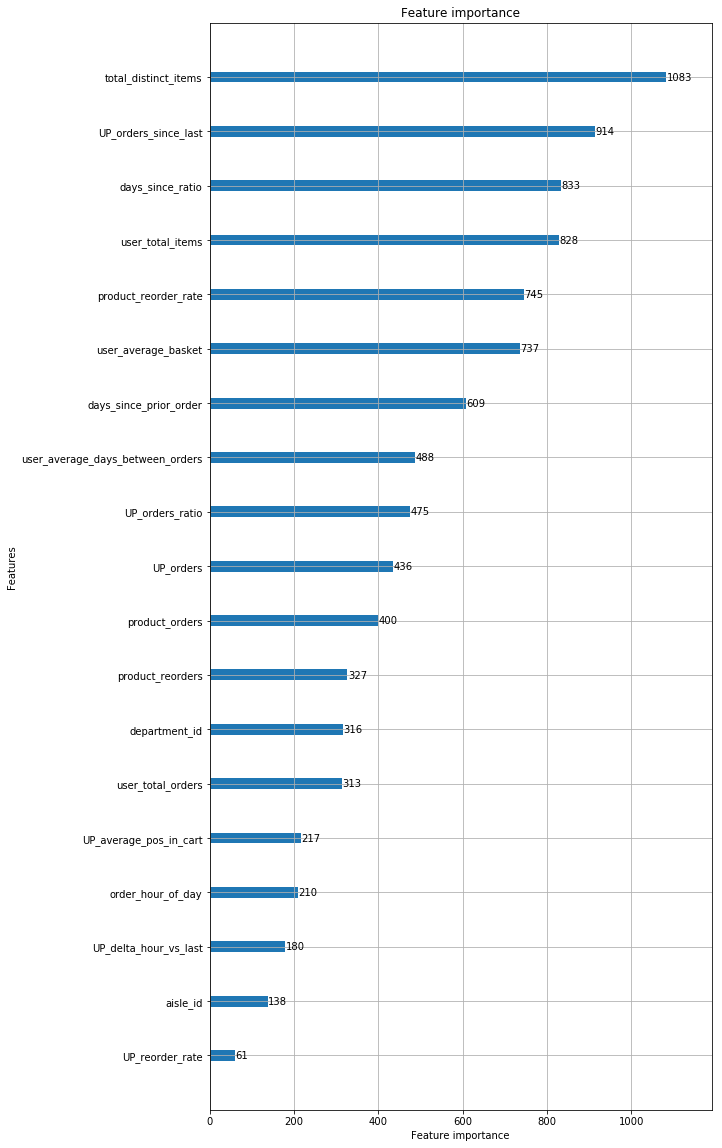

In [37]:
%matplotlib inline 
lgb.plot_importance(bst, figsize=(9,20))

# test

In [22]:
test_df.head()

,user_id,order_id,product_id
0,3,2774568,17668
1,3,2774568,44683
2,3,2774568,48523
3,3,2774568,21903
4,3,2774568,14992


In [23]:
print('user related features')
test_df['user_id'] = test_df.order_id.map(orders.user_id).astype(np.int32)
test_df['user_total_orders'] = test_df.user_id.map(users.nb_orders)
test_df['user_total_items'] = test_df.user_id.map(users.total_items)
test_df['total_distinct_items'] = test_df.user_id.map(users.total_distinct_items)
test_df['user_average_days_between_orders'] = test_df.user_id.map(users.average_days_between_orders)
test_df['user_average_basket'] =  test_df.user_id.map(users.average_basket)

user related features


In [24]:
test_df.head()

,user_id,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket
0,3,2774568,17668,13,88,33,12.0,6.769231
1,3,2774568,44683,13,88,33,12.0,6.769231
2,3,2774568,48523,13,88,33,12.0,6.769231
3,3,2774568,21903,13,88,33,12.0,6.769231
4,3,2774568,14992,13,88,33,12.0,6.769231


In [25]:
print('order related features')
# df['dow'] = df.order_id.map(orders.order_dow)
test_df['order_hour_of_day'] = test_df.order_id.map(orders.order_hour_of_day)
test_df['days_since_prior_order'] = test_df.order_id.map(orders.days_since_prior_order)
test_df['days_since_ratio'] = test_df.days_since_prior_order / test_df.user_average_days_between_orders

order related features


In [26]:
test_df.head()

,user_id,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio
0,3,2774568,17668,13,88,33,12.0,6.769231,15,11.0,0.916667
1,3,2774568,44683,13,88,33,12.0,6.769231,15,11.0,0.916667
2,3,2774568,48523,13,88,33,12.0,6.769231,15,11.0,0.916667
3,3,2774568,21903,13,88,33,12.0,6.769231,15,11.0,0.916667
4,3,2774568,14992,13,88,33,12.0,6.769231,15,11.0,0.916667


In [27]:
print('product related features')
test_df['aisle_id'] = test_df.product_id.map(products.aisle_id).astype(np.int8)
test_df['department_id'] = test_df.product_id.map(products.department_id).astype(np.int8)
test_df['product_orders'] = test_df.product_id.map(products.orders).astype(np.float32)
test_df['product_reorders'] = test_df.product_id.map(products.reorders).astype(np.float32)
test_df['product_reorder_rate'] = test_df.product_id.map(products.reorder_rate)

product related features


In [47]:
test_df.head()

,user_id,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,...,product_reorder_rate,z,UP_orders,UP_orders_ratio,UP_last_order_id,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last,pred
0,3,2774568,17668,13,88,33,12.0,6.769231,15,11.0,...,0.578199,317668,5,0.384615,521107,3.60,0.384615,2,3,0.354673
1,3,2774568,44683,13,88,33,12.0,6.769231,15,11.0,...,0.537868,344683,2,0.153846,1972919,9.50,0.153846,7,1,0.068937
2,3,2774568,48523,13,88,33,12.0,6.769231,15,11.0,...,0.463248,348523,2,0.153846,3160850,6.50,0.153846,4,1,0.086308
3,3,2774568,21903,13,88,33,12.0,6.769231,15,11.0,...,0.772500,321903,8,0.615385,1402502,4.25,0.615385,1,0,0.647782
4,3,2774568,14992,13,88,33,12.0,6.769231,15,11.0,...,0.582820,314992,2,0.153846,1839752,7.00,0.153846,6,0,0.085119


In [29]:
print('user_X_product related features')
test_df['z'] = test_df.user_id * 100000 + test_df.product_id
test_df['UP_orders'] = test_df.z.map(userXproduct.nb_orders)
test_df['UP_orders_ratio'] = (test_df.UP_orders / test_df.user_total_orders).astype(np.float32)
test_df['UP_last_order_id'] = test_df.z.map(userXproduct.last_order_id)
test_df['UP_average_pos_in_cart'] = (test_df.z.map(userXproduct.sum_pos_in_cart) / test_df.UP_orders).astype(np.float32)
test_df['UP_reorder_rate'] = (test_df.UP_orders / test_df.user_total_orders).astype(np.float32)
test_df['UP_orders_since_last'] = test_df.user_total_orders - test_df.UP_last_order_id.map(orders.order_number)
test_df['UP_delta_hour_vs_last'] = abs(test_df.order_hour_of_day - test_df.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x)).astype(np.int8)

user_X_product related features


In [30]:
test_df.head()

,user_id,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,...,product_reorders,product_reorder_rate,z,UP_orders,UP_orders_ratio,UP_last_order_id,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last
0,3,2774568,17668,13,88,33,12.0,6.769231,15,11.0,...,1220.0,0.578199,317668,5,0.384615,521107,3.60,0.384615,2,3
1,3,2774568,44683,13,88,33,12.0,6.769231,15,11.0,...,11981.0,0.537868,344683,2,0.153846,1972919,9.50,0.153846,7,1
2,3,2774568,48523,13,88,33,12.0,6.769231,15,11.0,...,2376.0,0.463248,348523,2,0.153846,3160850,6.50,0.153846,4,1
3,3,2774568,21903,13,88,33,12.0,6.769231,15,11.0,...,186884.0,0.772500,321903,8,0.615385,1402502,4.25,0.615385,1,0
4,3,2774568,14992,13,88,33,12.0,6.769231,15,11.0,...,16942.0,0.582820,314992,2,0.153846,1839752,7.00,0.153846,6,0


# prediction

In [40]:
print('light GBM predict')
preds = bst.predict(test_df[f_to_use])

test_df['pred'] = preds

test_df.head()

light GBM predict


,user_id,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,...,product_reorder_rate,z,UP_orders,UP_orders_ratio,UP_last_order_id,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last,pred
0,3,2774568,17668,13,88,33,12.0,6.769231,15,11.0,...,0.578199,317668,5,0.384615,521107,3.60,0.384615,2,3,0.354673
1,3,2774568,44683,13,88,33,12.0,6.769231,15,11.0,...,0.537868,344683,2,0.153846,1972919,9.50,0.153846,7,1,0.068937
2,3,2774568,48523,13,88,33,12.0,6.769231,15,11.0,...,0.463248,348523,2,0.153846,3160850,6.50,0.153846,4,1,0.086308
3,3,2774568,21903,13,88,33,12.0,6.769231,15,11.0,...,0.772500,321903,8,0.615385,1402502,4.25,0.615385,1,0,0.647782
4,3,2774568,14992,13,88,33,12.0,6.769231,15,11.0,...,0.582820,314992,2,0.153846,1839752,7.00,0.153846,6,0,0.085119


In [42]:
test_df[['user_id','order_id','product_id','pred']]

,user_id,order_id,product_id,pred
0,3,2774568,17668,0.354673
1,3,2774568,44683,0.068937
2,3,2774568,48523,0.086308
3,3,2774568,21903,0.647782
4,3,2774568,14992,0.085119
5,3,2774568,21137,0.069190
6,3,2774568,32402,0.198040
7,3,2774568,22035,0.157735
8,3,2774568,49683,0.046901
9,3,2774568,39190,0.756229


In [43]:
TRESHOLD = 0.22  # guess, should be tuned with crossval on a subset of train data

d = dict()
for row in test_df.itertuples():
    if row.pred > TRESHOLD:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in test_orders.order_id:
    if order not in d:
        d[order] = 'None'

In [44]:
sub = pd.DataFrame.from_dict(d, orient='index')

sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']

In [45]:
sub

,order_id,products
0,1654153,30233 33827 39046 44678 19086 47766 35102 4739...
1,1572866,27521 47626 37646 7054 49683 22963 19660 27086...
2,1703943,37710
3,1703945,11520 44306 48309 40311 4605
4,3276811,5406 18339 47780 32299 28204 3161 8153 40545 4...
5,131084,45066 21903 47890 47900 18465 21295 18883 2170...
6,3145741,9358 16797 21292 12341 35652 33768 8048 4724
7,655374,30252 19511 30949 42736 24852 38689
8,1331179,24852 1069 23909
9,2621456,40709 48015 9623 15902 27038 25001 47866 43580...


In [46]:
sub.to_csv('sub.csv', index=False)